 Анастасия Плавина

## Тема: Дерево решений

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import model_selection
from sklearn import datasets

import numpy as np

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).


In [2]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 3, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=1234)


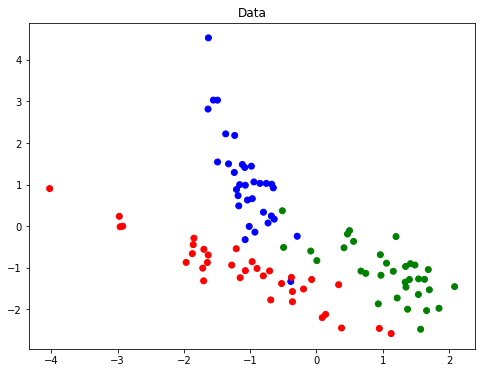

In [3]:
colors = ListedColormap(['red', 'blue', 'green'])

plt.figure(figsize=(8,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

plt.title('Data')
plt.show()

In [4]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
class Leaf:
    
    def __init__(self, data, labels, data_type):
        self.data = data
        self.labels = labels
        self.prediction = self.predict(data_type)
        
    def predict(self, data_type):
        
        if data_type == 'objects':  
            # подсчет количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1

            return max(classes, key=classes.get)
            
        elif data_type == 'numbers':
            return np.mean(self.labels)

In [6]:
def build_tree(data, labels, criterion_type, data_type, depth_limit=8, leaf_limit=10):

    quality, t, index = find_best_split(data, labels, criterion_type)

    # прекращаем рекурсию
    if quality == 0 or depth_limit == 0 or leaf_limit==1:
        return Leaf(data, labels, data_type), leaf_limit-1


    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    false_branch, leaf_limit = build_tree(false_data, false_labels, criterion_type, data_type, depth_limit-1, leaf_limit-1)
    true_branch, leaf_limit = build_tree(true_data, true_labels, criterion_type, data_type, depth_limit-1, leaf_limit+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), leaf_limit


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels, criterion_type):

    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    if criterion_type == 'gini':
        current_criterion = gini(labels)
    elif criterion_type == 'entropy':
        current_criterion = entropy(labels)
    elif criterion_type == 'variance':
        current_criterion = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_criterion, criterion_type)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity


def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p)

    return entropy


def variance(data):
    return np.var(data) 


def quality(left_labels, right_labels, current_criterion, criterion_type):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    if criterion_type == 'gini':
        return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif criterion_type == 'entropy':
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    elif criterion_type == 'variance':
        return current_criterion - p * variance(left_labels) - (1 - p) * variance(right_labels)



def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.



In [7]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [8]:
# gini
my_tree1, _ = build_tree(train_data, train_labels, criterion_type='gini', data_type='objects')
train_answers1 = predict(train_data, my_tree1)
test_answers1 = predict(test_data, my_tree1)

In [9]:
# entropy
my_tree2, _ = build_tree(train_data, train_labels, criterion_type='entropy', data_type='objects')
train_answers2 = predict(train_data, my_tree2)
test_answers2 = predict(test_data, my_tree2)

In [10]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [11]:
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

						GINI CRITERION


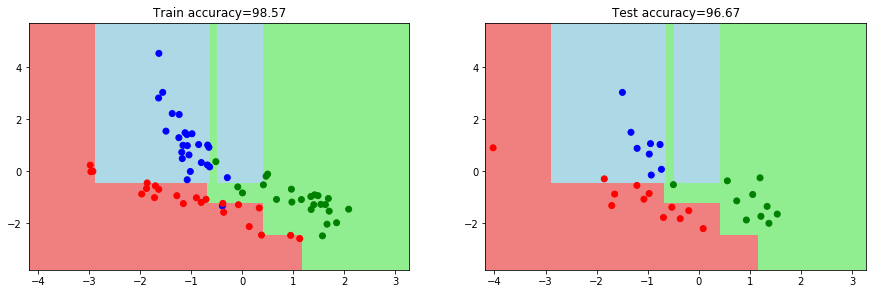

						ENTROPY CRITERION


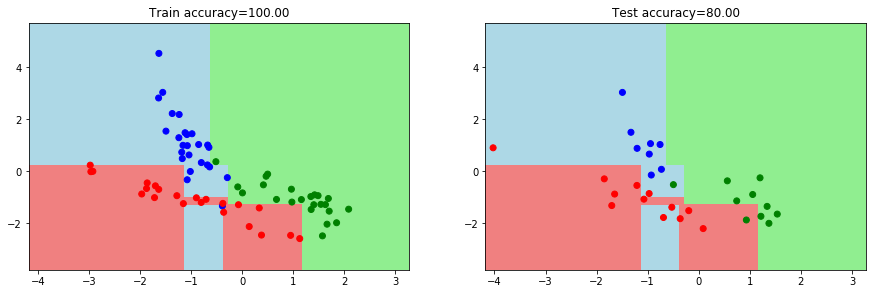

In [12]:
## GINI

plt.figure(figsize = (15, 10))
print('\t\t\t\t\t\tGINI CRITERION')

# график обучающей выборки
plt.subplot(2,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree1)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={accuracy_metric(train_labels, train_answers1):.2f}')

# график тестовой выборки
plt.subplot(2,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={accuracy_metric(test_labels, test_answers1):.2f}')
plt.show()


## ENTROPY
plt.figure(figsize = (15, 10))
print('\t\t\t\t\t\tENTROPY CRITERION')


# график обучающей выборки
plt.subplot(2,2,3)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree2)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={accuracy_metric(train_labels, train_answers2):.2f}')

# график тестовой выборки
plt.subplot(2,2,4)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={accuracy_metric(test_labels, test_answers2):.2f}')

plt.show()

**Вывод:** обучение дерева с критерием Джини дало менее точное предсказание на тренировочной выборке, но при этом показало значительно более хорошие результаты на тесте, чем энтропия.

3*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [13]:
X, y = datasets.make_regression(n_samples=500, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 7, random_state = 2)

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size = 0.3, random_state = 1)

In [15]:
my_tree3, _ = build_tree(X_train, y_train, criterion_type='variance', data_type='numbers', depth_limit=6, leaf_limit=200)
train_answers3 = predict(X_train, my_tree3)
test_answers3 = predict(X_test, my_tree3)

In [16]:
def r2(y, y_pred):
    return 1 - np.var(y - y_pred) / np.var(y)

In [17]:
# R2 на тренировочной выборке
r2(y_train, train_answers3)

0.9779979679033782

In [18]:
# R2 на тестовой выборке
r2(y_test, test_answers3)

0.9308651709722089